# Statistical Inferences

## A. Identifying Data Duplication Rates Through Hypothesis Testing

#### Libraries Setup:

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy.stats import (
    mannwhitneyu,
    norm,
    poisson,
    ttest_1samp,
    ttest_ind,
    ttest_rel,
    wilcoxon,
)
from statsmodels.stats.proportion import proportions_ztest

sns.set_theme("notebook", style="whitegrid")
warnings.filterwarnings("ignore")

#### Data Importing and Preparations

To protect the privacy, we take steps to ensure the accuracy of our data breach notification lists. Before creating these lists, we identify and cluster duplicate records using advanced algorithms, including rule-based and machine learning techniques. This process significantly reduces the amount of data we handle while preserving all relevant information.

We track data processed for each project, including:
    
      1. Number of records extracted and consolidated
      2. Number of duplicate records identified
      3. Number of duplicates manually reviewed by analysts for additional quality assurance
      4. % of duplication

These information can be seen in the below pandas dataframe

In [2]:
df_delivery = pd.read_excel(r"C:\datos\SSBB\DATA\dbas_sds_project_delivery_v1.xlsx")

In [3]:
df_delivery.head()

,project_name,before_rollup,after_rollup,manual_checks,diff,duplication_perc
0,PROJECT_1,1211,184,250,66.000000,84.805945
1,PROJECT_2,170210,20808,29568,8760.000000,87.775101
2,PROJECT_3,40713,27629,16856,61.008361,32.137155
3,PROJECT_4,53038,6396,9157,2761.000000,87.940722
4,PROJECT_5,1318,169,389,220.000000,87.177542


We want to assess data deduplication efficiency for our algorithms. We'll analyze 90 projects from the past 2 months to determine:

        1. Duplication rate per project
        2. Algorithm performance
        3. Post-processing manual effort required

### A(1). Non-Parametric Test:Wilcoxon

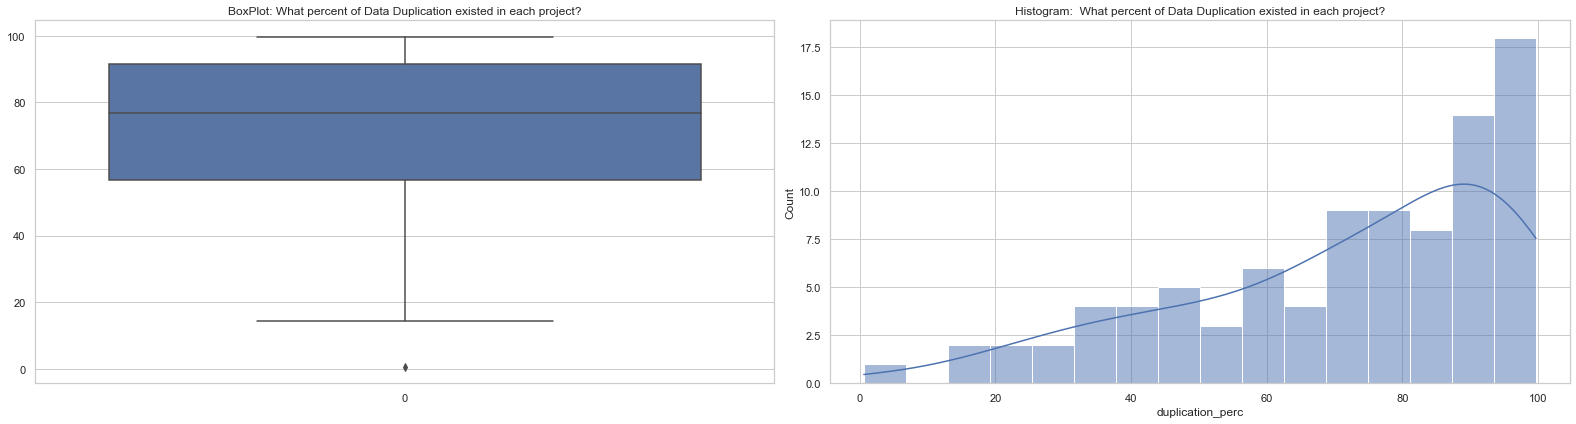

In [4]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.boxplot(df_delivery["duplication_perc"], ax=ax1)
p2 = sns.histplot(df_delivery["duplication_perc"], ax=ax2, kde=True, bins=16)
p1.set_title("BoxPlot: What percent of Data Duplication existed in each project?")
p2.set_title("Histogram:  What percent of Data Duplication existed in each project?")
plt.tight_layout()
plt.show()

**Notes**

1. The distribution of data duplication rates exhibits a left skew.

2. As our data exhibits a non-normal distribution, a non-parametric test is more appropriate for this scenario to avoid potential biases from assuming normality.

**Hypothesis**

            Ho: Half of the project data has a deduplication value of 75% 
            Ha: Half of the project data does not have a deduplication value of 75%

In [5]:
dedup_perc = df_delivery["duplication_perc"]

_stat, _p = wilcoxon(dedup_perc - 75)


print(
    f"P-Value Caluclated is:{round(_p,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)

P-Value Caluclated is:0.607 which is greater than to 0.05, hence we failed to reject the null hypothesis.


### A(2). Non-Parametric Test:Mann-Whitneyu

We want to investigate whether the percentage of duplicate data is correlated with project size. Specifically, we aim to determine if:

- Smaller projects tend to have a higher duplication rate.
- Larger projects tend to have a lower duplication rate. (or vice versa)

We have introduced a new variable named "record group" to facilitate analysis. This variable groups projects according to the size of their consolidated data set (number of data points).

In [6]:
# Creatinng record group column with different conditions
df_delivery.loc[
    ((df_delivery["before_rollup"] >= 1) & (df_delivery["before_rollup"] < 1500)),
    "record_group",
] = "1-1499"

df_delivery.loc[
    ((df_delivery["before_rollup"] >= 1500) & (df_delivery["before_rollup"] < 18000)),
    "record_group",
] = "1500-17999"

df_delivery.loc[
    ((df_delivery["before_rollup"] >= 18000) & (df_delivery["before_rollup"] < 120000)),
    "record_group",
] = "18000-119999"

df_delivery.loc[
    (
        (df_delivery["before_rollup"] >= 120000)
        & (df_delivery["before_rollup"] < 1000000)
    ),
    "record_group",
] = "120000-999999"

df_delivery.loc[(df_delivery["before_rollup"] >= 1000000), "record_group"] = "1M"


df_record_group = df_delivery.value_counts("record_group").reset_index()

df_record_group["total"] = sum(df_record_group["count"])

df_record_group["perc_of"] = df_record_group["count"] / df_record_group["total"]

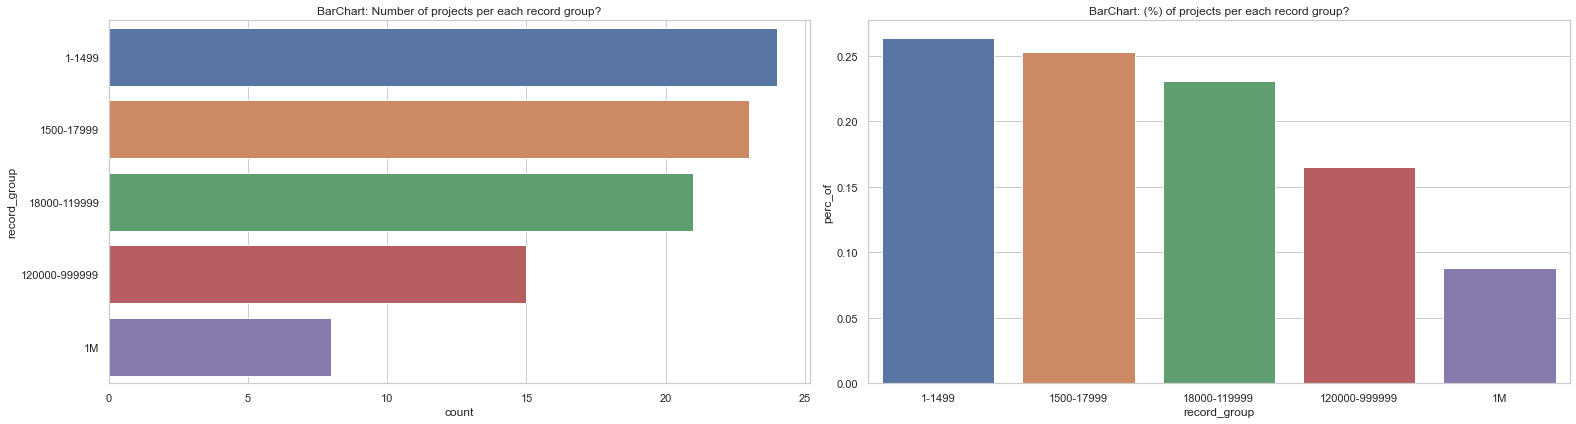

In [7]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.barplot(df_record_group, y="record_group", x="count", ax=ax1)
p2 = sns.barplot(df_record_group, x="record_group", y="perc_of", ax=ax2)
p1.set_title("BarChart: Number of projects per each record group?")
p2.set_title("BarChart: (%) of projects per each record group?")
plt.tight_layout()
plt.show()

In [8]:
df_record_A = df_delivery.loc[
    df_delivery["record_group"].isin(["1-1499", "1500-17999"]), ["duplication_perc"]
]

df_record_B = df_delivery.loc[
    df_delivery["record_group"].isin(["18000-119999", "120000-999999"]),
    ["duplication_perc"],
]

We previously defined two record groups: Group A includes data observations ranging from 1 to 17.9 thousand, and Group B includes observations from 18 thousand to 100 thousand.

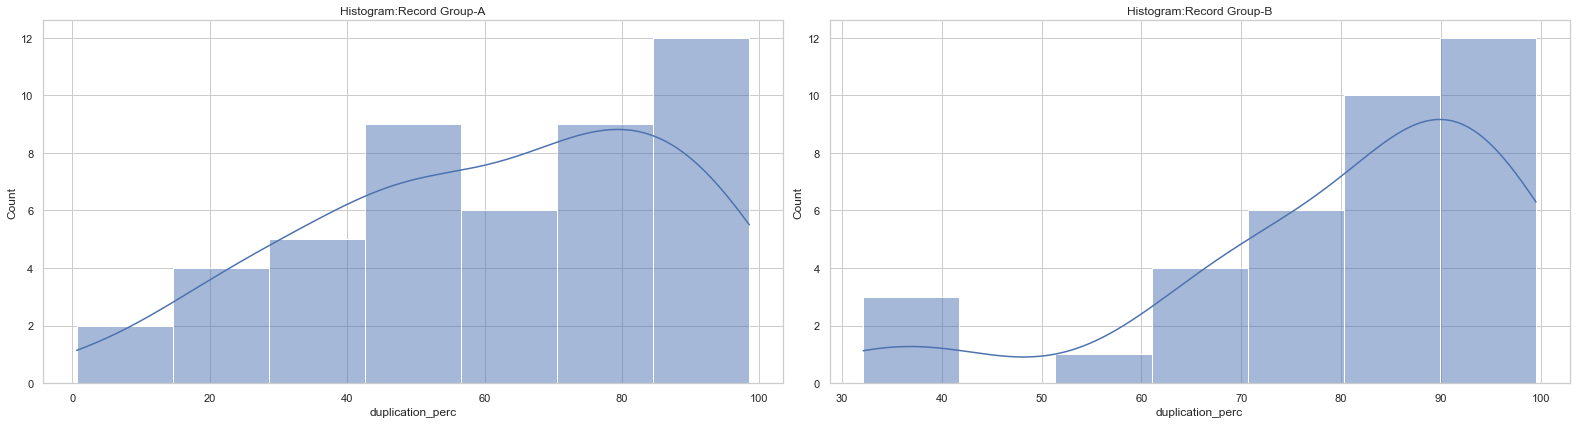

In [9]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_record_A["duplication_perc"], ax=ax1, kde=True)
p2 = sns.histplot(df_record_B["duplication_perc"], ax=ax2, kde=True)
p1.set_title("Histogram:Record Group-A")
p2.set_title("Histogram:Record Group-B")
plt.tight_layout()
plt.show()

**Notes**

1. Both record groups show a left-skewed distribution in the data.

2. Since the data in both record groups exhibits a non-normal distribution, a non-parametric test like the Mann-Whitney U test is more appropriate.

**Hypothesis**

            Ho: On average, the amount of data duplication is the same for Record Group A and Record Group B.
            Ha: On average, the amount of data duplication is different for Record Group A and Record Group B.

In [10]:
_stat, _pval = mannwhitneyu(df_record_A, df_record_B)

print(
    f"P-Value Caluclated is:{round(_pval[0],3)} which is lesser than to 0.05, hence we can reject the null hypothesis in favour of alternative hypothesis"
)

P-Value Caluclated is:0.001 which is lesser than to 0.05, hence we can reject the null hypothesis in favour of alternative hypothesis


#### Conclusions and Inferences

- Half of the project data has a deduplication value of 75% 
- On average, the amount of data duplication is different for Record Group A and Record Group B.

Analysis of data deduplication revealed that approximately half the dataset exhibits a 75% deduplication rate. However, the level of duplication appears to vary significantly between Record Group A and Record Group B, suggesting potential structural differences in the data within these groups.

## B. Hypothesis Testing Approach to E-Commerce and Food Delivery Customer Data

#### Data Importing and Preparations

In [11]:
# fill in the file path from where data to be imported
df_cs_ecom = pd.read_excel(r"C:\datos\SSBB\DATA\customer_survey_ecom.xlsx")

In [12]:
# no fo rows and columns
df_cs_ecom.shape

(28, 10)

In [13]:
# first five observations
df_cs_ecom.head()

,Customer,Gender,Age,How satisfied were you with the overall quality of online services available in India.,To what extent you use the e-commerce/online delivery services,How satisfied were you with the following e-commerce/delivery companies ? [Amazon],How satisfied were you with the following e-commerce/delivery companies ? [Flipkart],How satisfied were you with the following e-commerce/delivery companies ? [Swiggy],How satisfied were you with the following e-commerce/delivery companies ? [Zomato],How satisfied were you with the following e-commerce/delivery companies ? [Others]
0,CUST_1,Male,34,7,6,9,7,7,7,5
1,CUST_2,Male,33,9,9,10,3,7,7,7
2,CUST_3,Female,34,8,10,10,3,4,4,8
3,CUST_4,Male,32,8,4,8,8,5,8,5
4,CUST_5,Female,40,7,4,7,7,5,5,4


In [14]:
# columns
df_cs_ecom.columns

Index(['Customer', 'Gender', 'Age',
       'How satisfied were you with the overall quality of online services available in India.',
       'To what extent you use the e-commerce/online delivery services ',
       'How satisfied were you with the following e-commerce/delivery companies ? [Amazon]',
       'How satisfied were you with the following e-commerce/delivery companies ? [Flipkart]',
       'How satisfied were you with the following e-commerce/delivery companies ? [Swiggy]',
       'How satisfied were you with the following e-commerce/delivery companies ? [Zomato]',
       'How satisfied were you with the following e-commerce/delivery companies ? [Others]'],
      dtype='object')

In [15]:
# renaming column names from longer text to short
df_cs_ecom.columns = [
    "customer",
    "gender",
    "age",
    "satiesfied_score",
    "usage",
    "amazon_sc",
    "flipkart_sc",
    "swiggy_sc",
    "zomato_sc",
    "others_sc",
]

In [16]:
# first 5 observations afrer renaming the columns
df_cs_ecom.head()

,customer,gender,age,satiesfied_score,usage,amazon_sc,flipkart_sc,swiggy_sc,zomato_sc,others_sc
0,CUST_1,Male,34,7,6,9,7,7,7,5
1,CUST_2,Male,33,9,9,10,3,7,7,7
2,CUST_3,Female,34,8,10,10,3,4,4,8
3,CUST_4,Male,32,8,4,8,8,5,8,5
4,CUST_5,Female,40,7,4,7,7,5,5,4


This study aims to analyze an online survey conducted in India to understand user demographics and preferences for e-commerce and food delivery services. The survey collected data on:

- Demographics: Age and gender
- Overall Satisfaction: Satisfaction with the general quality of online services in India
- Service Usage: Frequency of using e-commerce/online delivery services
- Company-Specific Satisfaction: Satisfaction levels with specific companies like Amazon, Flipkart, Swiggy, Zomato, and others

By analyzing this data, we hope to answer key questions such as:

- What are the demographic characteristics of our typical customer (age, gender)?
- Are there any gender differences in online service usage or satisfaction?
- How satisfied are users with the overall quality of online services in India?
- Which e-commerce/delivery services do users prefer the most?
- Is there a correlation between overall satisfaction and usage of specific companies?

### B(1):T-Test-1Sample 

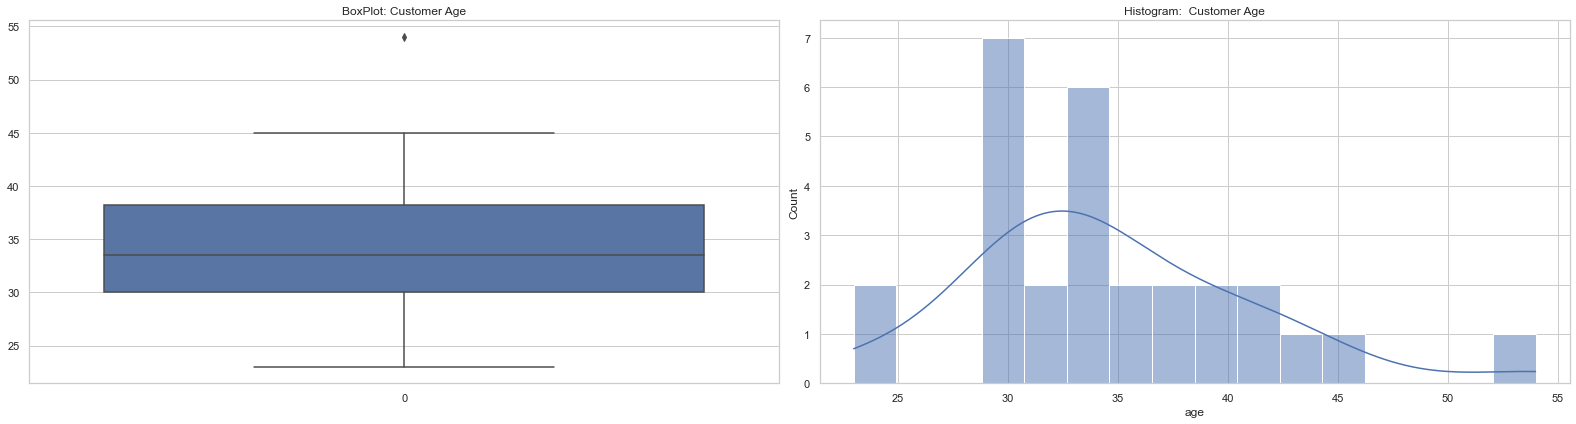

In [17]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.boxplot(df_cs_ecom["age"], ax=ax1)
p2 = sns.histplot(df_cs_ecom["age"], ax=ax2, kde=True, bins=16)
p1.set_title("BoxPlot: Customer Age")
p2.set_title("Histogram:  Customer Age")
plt.tight_layout()
plt.show()

**Notes**
1. Based on a sample of approximately 30 observations, the data suggests that the age is normally distributed. and the ages are independent

**Hypothesis**

           Ho: The average age of customers using both e-commerce and food delivery services is 33 years old.
           Ha: The average age of customers using both e-commerce and food delivery services is not 33 years old.

In [18]:
_stat, _pval = ttest_1samp(df_cs_ecom["age"], popmean=33)

print(
    f"P-Value Caluclated is:{round(_pval,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)

P-Value Caluclated is:0.204 which is greater than to 0.05, hence we failed to reject the null hypothesis.


### B(2):T-test-2-Sample

In [19]:
# Sub selection gender, age and usage
df_gender_age_usage = df_cs_ecom[["gender", "age", "usage"]]
# Male- Age and Usage Data
df_cs_ecom_male = df_gender_age_usage[df_gender_age_usage["gender"] == "Male"]
# Female - Age and Usage data
df_cs_ecom_female = df_gender_age_usage[df_gender_age_usage["gender"] == "Female"]

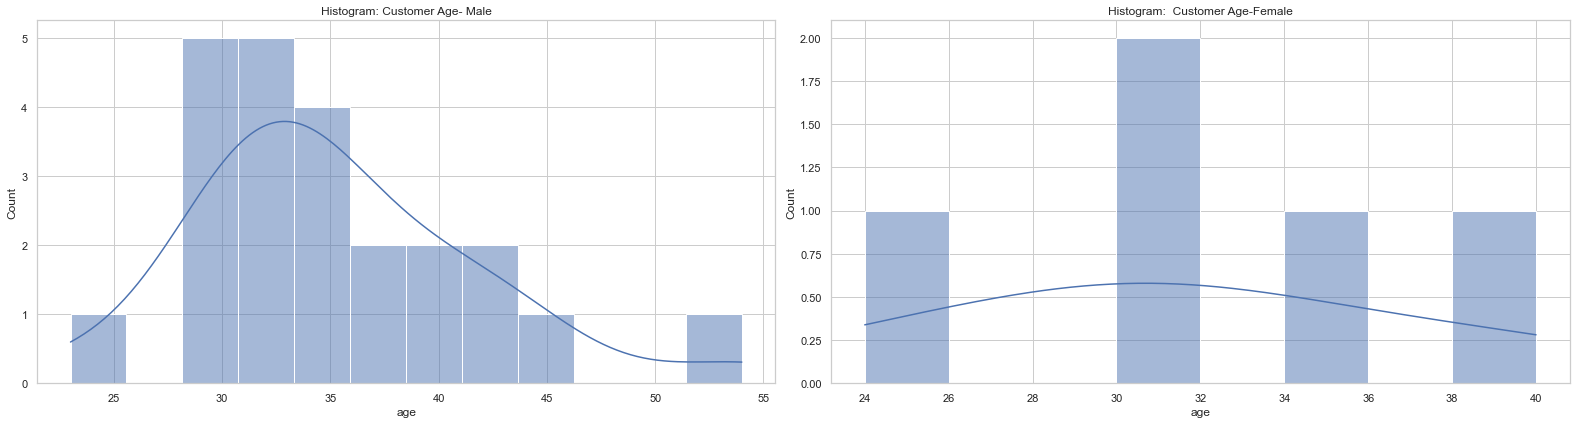

In [20]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_cs_ecom_male["age"], ax=ax1, kde=True, bins=12)
p2 = sns.histplot(df_cs_ecom_female["age"], ax=ax2, kde=True, bins=8)
p1.set_title("Histogram: Customer Age- Male")
p2.set_title("Histogram:  Customer Age-Female")
plt.tight_layout()
plt.show()

**Notes**
1. It suggests that the ages of both male and female customers are likely normally distributed.

**Hypothesis**

            Ho: There is no difference between mean age of Female and Male Customers
            Ha: There is a difference between mean age of Female and Male Customers

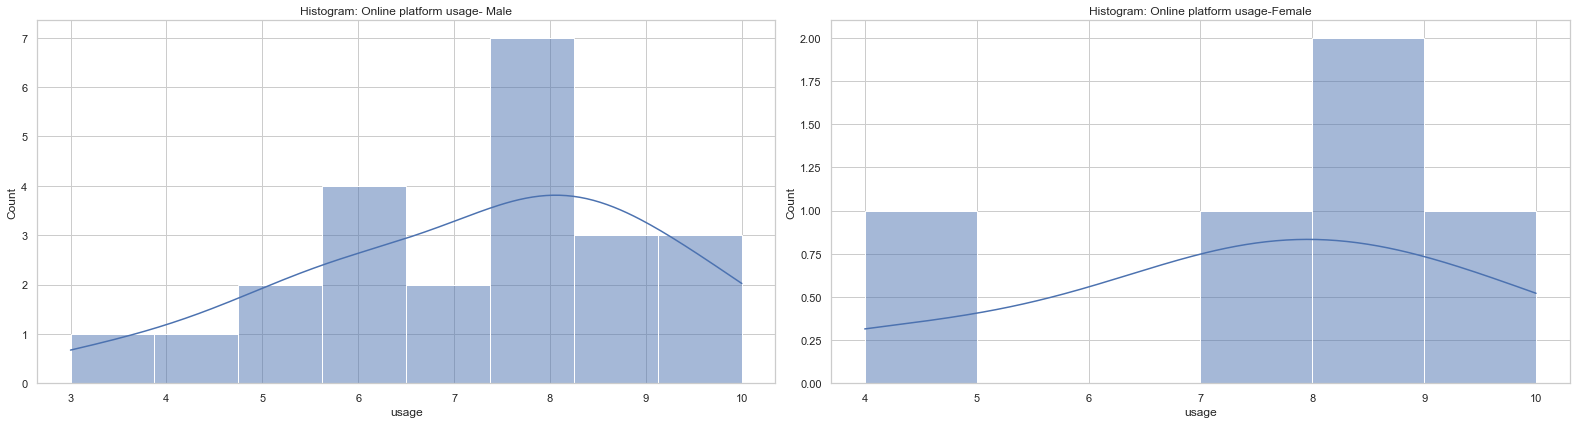

In [21]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
p1 = sns.histplot(df_cs_ecom_male["usage"], ax=ax1, kde=True, bins=8)
p2 = sns.histplot(df_cs_ecom_female["usage"], ax=ax2, kde=True, bins=6)
p1.set_title("Histogram: Online platform usage- Male")
p2.set_title("Histogram: Online platform usage-Female")
plt.tight_layout()
plt.show()

In [22]:
# Perform 2-sample t-test on male and female ages
_stat, _pval = ttest_ind(df_cs_ecom_male["age"], df_cs_ecom_female["age"])

In [23]:
print(
    f"P-Value Caluclated is:{round(_pval,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)

P-Value Caluclated is:0.264 which is greater than to 0.05, hence we failed to reject the null hypothesis.


**Hypothesis**

            Ho: The average usage of the e-commerce platform is the same for female and male customers.
            Ha: The average usage of the e-commerce platform is different for female and male customers.

In [24]:
# Perform 2-sample t-test on male and female usages
_stat, _pval = ttest_ind(df_cs_ecom_male["usage"], df_cs_ecom_female["usage"])

print(
    f"P-Value Caluclated is:{round(_pval,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)

P-Value Caluclated is:0.922 which is greater than to 0.05, hence we failed to reject the null hypothesis.


### B(3): 1-Proportion Test

In [25]:
df_ecom_plat_score = df_cs_ecom[
    ["amazon_sc", "flipkart_sc", "swiggy_sc", "zomato_sc"]
].melt()

df_ecom_plat_score.columns = ["service_name", "satiesfied_score"]

df_ecom_plat_score.loc[
    df_ecom_plat_score["satiesfied_score"] >= 8, "is_customer_satiesfied"
] = "Yes"

df_ecom_plat_score.loc[
    df_ecom_plat_score["satiesfied_score"] < 8, "is_customer_satiesfied"
] = "No"

We transformed the customer satisfaction scores for Amazon, Flipkart, Swiggy, and Zomato. A new binary column was added to indicate customer satisfaction. Scores 8 and above are categorized as "Yes" (satisfied), while scores below 8 are categorized as "No" (not satisfied).

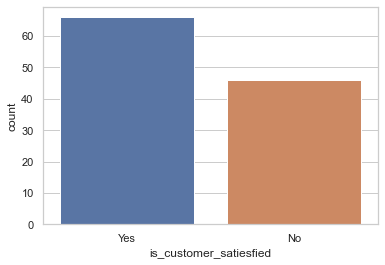

In [26]:
df_sc = df_ecom_plat_score.value_counts("is_customer_satiesfied").reset_index()
sns.barplot(df_sc, x="is_customer_satiesfied", y="count")
plt.show()

**Hypothesis**

            Ho: The true satisfaction rate is 80%.
            Ha: The true satisfaction rate is different from 80%.

In [27]:
# Number of satisfied customers
successes = 66
# sample size
trials = 112
# Expected proportion of satisfied customers
hypothesized_proportion = 0.8

# Perform the test
z_statistic, p_value = proportions_ztest(
    count=successes, nobs=trials, value=hypothesized_proportion
)

print(
    f"P-Value Caluclated is:{round(p_value,3)} which is less than to 0.05, hence we can reject the null hypothesis."
)

P-Value Caluclated is:0.0 which is less than to 0.05, hence we can reject the null hypothesis.


### B(4): 2-Proportion Test

In [28]:
df_ser_amz_flpkart = df_ecom_plat_score[
    df_ecom_plat_score["service_name"].isin(["amazon_sc", "flipkart_sc"])
]

In [29]:
df_sc_amzflp = (
    df_ser_amz_flpkart.groupby(["service_name", "is_customer_satiesfied"])
    .count()
    .reset_index()
)

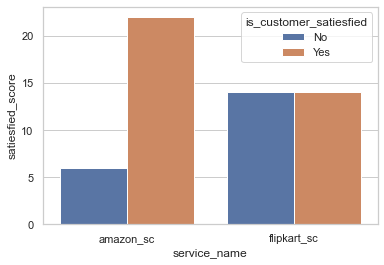

In [30]:
sns.barplot(
    df_sc_amzflp, x="service_name", y="satiesfied_score", hue="is_customer_satiesfied"
)
plt.show()

**Hypothesis**

            Ho: The average level of customer satisfaction with Amazon is equal to the average level of customer satisfaction with Flipkart.
            Ha: The average level of customer satisfaction with Amazon is not equal to the average level of customer satisfaction with Flipkart.

In [31]:
# Number of successes in group 1 and group2
success = np.array([22, 14])
# Total trials in group 1 and group 2 (sample size)
trials = np.array([28, 28])

# Perform the test (assuming equal variances)
z_statistic, p_value = proportions_ztest(
    count=success, nobs=trials, alternative="two-sided"
)

print(
    f"P-Value Caluclated is:{round(p_value,3)} which is less than to 0.05, hence we can reject the null hypothesis."
)

P-Value Caluclated is:0.026 which is less than to 0.05, hence we can reject the null hypothesis.


In [32]:
df_ecom_plat_score.loc[
    df_ecom_plat_score["service_name"].isin(["amazon_sc", "flipkart_sc"]),
    "service_type",
] = "E-Commerce"
df_ecom_plat_score.loc[
    df_ecom_plat_score["service_name"].isin(["swiggy_sc", "zomato_sc"]), "service_type"
] = "OnlineFood"

In [33]:
df_sc_ef = (
    df_ecom_plat_score.groupby(["service_type", "is_customer_satiesfied"])
    .count()
    .reset_index()
)

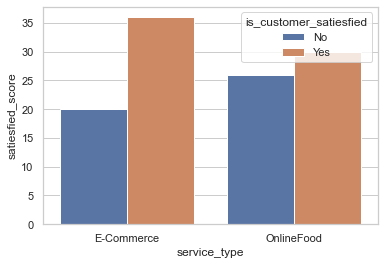

In [34]:
sns.barplot(
    df_sc_ef, x="service_type", y="satiesfied_score", hue="is_customer_satiesfied"
)
plt.show()

**Hypothesis**

            Ho: The average level of customer satisfaction with E-commerce services is equal to the average level of customer satisfaction with Food Delivery services.
            Ha: The average level of customer satisfaction with E-commerce services is not equal to the average level of customer satisfaction with Food Delivery services.

In [35]:
# Number of successes in group 1 and group2
success = np.array([36, 30])
# Total trials in group 1 and group 2 (sample size)
trials = np.array([56, 56])
# Perform the test (assuming equal variances)
z_statistic, p_value = proportions_ztest(
    count=success, nobs=trials, alternative="two-sided"
)
print(
    f"P-Value Caluclated is:{round(p_value,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis."
)

P-Value Caluclated is:0.249 which is greater than to 0.05, hence we failed to reject the null hypothesis.


#### Conclusions and Inferences

- The average age of customers using both e-commerce and food delivery services is 33 years old.
- There is no difference between mean age of Female and Male Customers
- The true satisfaction rate is different from 80%.
- The average level of customer satisfaction with Amazon is not equal to the average level of customer satisfaction with Flipkart.
- The average level of customer satisfaction with E-commerce services is equal to the average level of customer satisfaction with Food Delivery services.


Our analysis revealed that the average customer using both e-commerce and food delivery services is 33 years old. Interestingly, gender does not seem to be a factor, as the mean age is similar for both female and male customers. Additionally, the true customer satisfaction rate deviates from the assumed 80%. While satisfaction levels differ between Amazon and Flipkart, surprisingly, the average satisfaction for e-commerce and food delivery services is statistically the same.

## C.Pareto Analysis

In [3]:
# Data Importing
df_causes = pd.read_excel(r'C:\data_analytics_projects\exploratory_data_analysis\notebooks\SSBB\W3\dbas_potential_cause.xlsx')

In [14]:
# Grouping on potential causes and sum of RPN
df_causes=df_causes.groupby('Potential Causes').sum('RPN').reset_index()
sorted_data = df_causes.sort_values(by=['RPN'], ascending=False)
sorted_data['cumulative_freq'] = sorted_data['RPN'].cumsum()
sorted_data['cumulative_pct'] = sorted_data['cumulative_freq'] / sorted_data['RPN'].sum() * 100

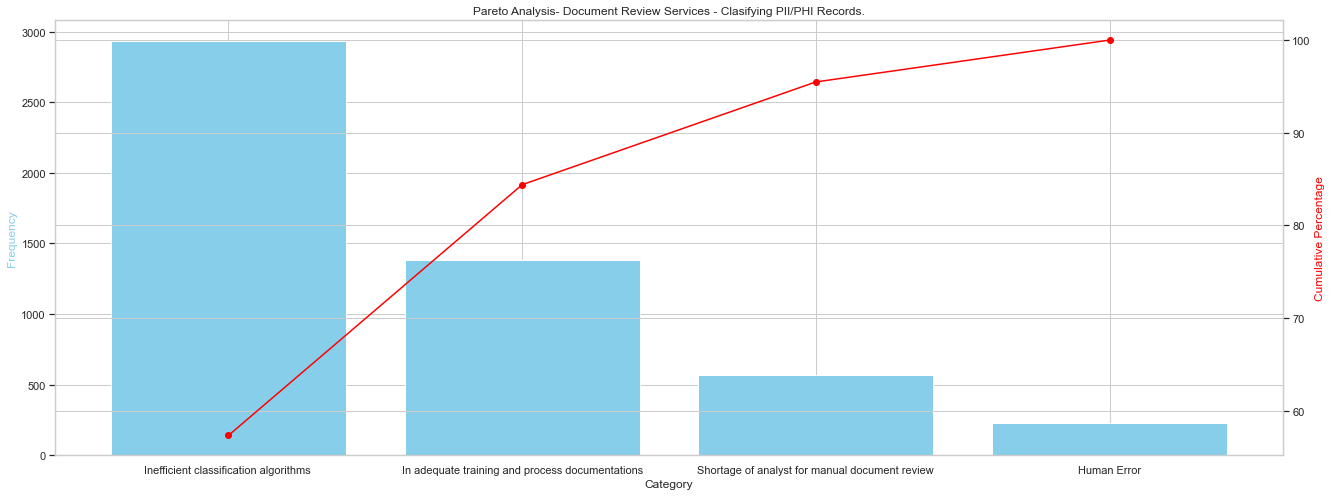

In [24]:
# Visualizations
fig, ax1 = plt.subplots(figsize=(22, 8))
ax2 = ax1.twinx()
ax1.bar(sorted_data['Potential Causes'], sorted_data['RPN'], color='skyblue')
ax2.plot(sorted_data['Potential Causes'], sorted_data['cumulative_pct'], color='red', marker='o', linestyle='-')
ax1.set_xlabel('Category')
ax1.set_ylabel('Frequency', color='skyblue')
ax2.set_ylabel('Cumulative Percentage', color='red')
plt.title('Pareto Analysis- Document Review Services - Clasifying PII/PHI Records.')
plt.show()